# Análise do PIB de países com Graph Neural Networks (GNN) Classification

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px


### Carregando o dataset com os países vizinhos

In [2]:
json_file_path = "nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())

### Carregando o dataset com os dados dos países

In [3]:
path = "countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')
df_gdp.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,American Samoa,Andorra
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,OCEANIA,WESTERN EUROPE
Population,31056997,3581655,32930091,57794,71201
Area (sq. mi.),647500,28748,2381740,199,468
Pop. Density (per sq. mi.),48,124.6,13.8,290.4,152.1
Coastline (coast/area ratio),0,1.26,0.04,58.29,0
Net migration,23.06,-4.93,-0.39,-20.71,6.6
Infant mortality (per 1000 births),163.07,21.52,31,9.27,4.05
GDP ($ per capita),700,4500,6000,8000,19000
Literacy (%),36,86.5,70,97,100


In [4]:
# px.choropleth(gapminder,
#     locations="iso_alpha",
#     color="lifeExp",
#     hover_name="country",
#     animation_frame="year",
#     color_continuous_scale=px.colors.sequential.Plasma,
#     projection="natural earth"
# )

In [5]:
### Removendo espaços ao final do nome dos países
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

### Alterando nomes de países para combinar os datasets

In [6]:
correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

In [7]:
df_gdp = df_gdp.replace({"Country": correspondence})

In [8]:
countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]

print(
"countries_df: ",len(countries_df),
"countries_nodes: ",len(countries_nodes),
"mismatch: ",len(mismatch),
"mismatch countries:", mismatch
)

countries_df:  227 countries_nodes:  195 mismatch:  4 mismatch countries: ['South Sudan', 'Montenegro', 'Vatican City', 'Palestine']


In [9]:
nodes = set(countries_nodes)-set(mismatch)
len(nodes)

191

### Dataset com países correspondentes

In [10]:
nodes_df = [i for i in nodes]
df = df_gdp[df_gdp['Country'].isin(nodes_df)]
df.head(5).T

,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,WESTERN EUROPE,SUB-SAHARAN AFRICA
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),163.07,21.52,31,4.05,191.19
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42


#### Tirando algumas colunas que não serão utilizadas na análise inicial

In [11]:
df.shape

(191, 20)

In [12]:
df.drop(['Region', 'Net migration', 'Infant mortality (per 1000 births)', 'Phones (per 1000)', 'Arable (%)', 'Crops (%)','Other (%)', 'Birthrate', 'Deathrate'], axis=1, inplace=True)
df.head(5).T

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42
Climate,1,3,1,3,NaN
Agriculture,0.38,0.232,0.101,NaN,0.096
Industry,0.24,0.188,0.6,NaN,0.658


array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>],
       [<AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Climate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>,
        <AxesSubplot:title={'center':'Industry'}>],
       [<AxesSubplot:title={'center':'Service'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

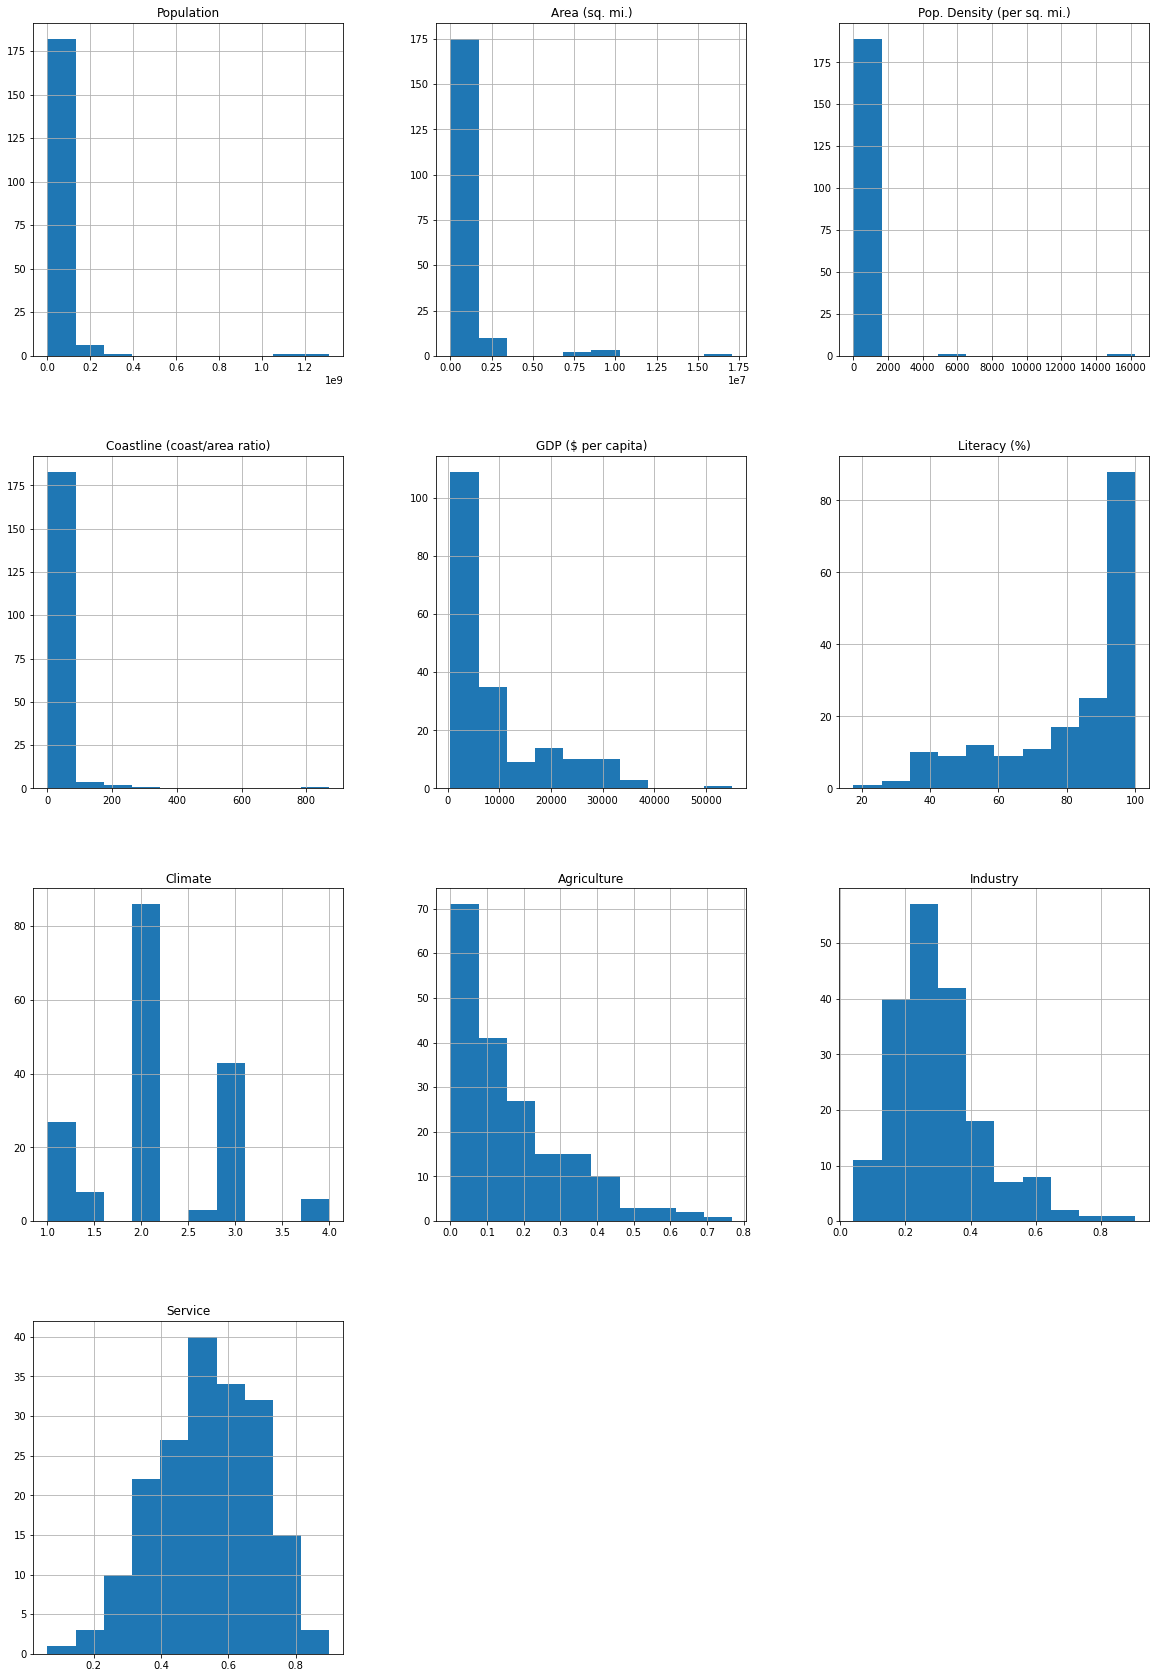

In [13]:
df.hist(figsize=(20,30))

In [14]:
df.describe()

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),GDP ($ per capita),Literacy (%),Climate,Agriculture,Industry,Service
count,1.910000e+02,1.910000e+02,191.000000,191.000000,191.000000,184.000000,173.000000,188.000000,187.000000,187.000000
mean,3.393533e+07,6.972754e+05,247.935602,14.933665,8787.434555,81.385326,2.147399,0.163165,0.298444,0.537957
std,1.278974e+08,1.930308e+06,1267.326189,72.322888,9915.301796,20.292039,0.735287,0.149766,0.134626,0.150079
min,1.181000e+04,2.000000e+00,1.800000,0.000000,500.000000,17.600000,1.000000,0.000000,0.040000,0.062000
25%,1.640698e+06,2.583550e+04,26.800000,0.045000,1750.000000,68.675000,2.000000,0.042250,0.208500,0.420500
50%,7.320815e+06,1.213200e+05,69.800000,0.400000,4800.000000,90.500000,2.000000,0.116500,0.286000,0.553000
75%,2.235656e+07,5.209850e+05,147.600000,2.825000,11400.000000,98.000000,3.000000,0.234750,0.354500,0.651000
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,55100.000000,100.000000,4.000000,0.769000,0.906000,0.900000


In [15]:
df_test = df.copy()

class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T

191


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42
Climate,1,3,1,3,NaN
Agriculture,0.38,0.232,0.101,NaN,0.096
Industry,0.24,0.188,0.6,NaN,0.658


In [16]:
# df.isna().sum()
df_test=df_test.dropna()   ### Só para testar por enquanto


In [17]:
df_test.shape

(165, 12)

In [18]:
###### Pré processamento inicial (para testar o tutorial)

df_test["Has coastline"] = df_test['Coastline (coast/area ratio)'].apply(lambda x: 0 if x == 0 else 1)

##### Pra esses 3 poderia pegar o maior para cada país
df_test["Industrial"] = df_test['Industry'].apply(lambda x: 0 if x <0.16 else 1)
df_test["Agricultural"] = df_test['Agriculture'].apply(lambda x: 0 if x <0.3 else 1)
df_test["Services"] = df_test['Service'].apply(lambda x: 0 if x <0.5 else 1)

df_test["High Literacy"] = df_test['Literacy (%)'].apply(lambda x: 0 if x <0.9 else 1)

## Usar OneHotEncoder para as Climate

est = KBinsDiscretizer(n_bins=4, encode='ordinal', 
                       strategy='quantile')
df_test['GDP'] = est.fit_transform(df_test[['GDP ($ per capita)']])
#### Mudar essa classificacao para https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2020-2021

df_test.drop(['GDP ($ per capita)','Coastline (coast/area ratio)', 'Industry', 'Agriculture', 'Service','Literacy (%)', 'Population', 'Area (sq. mi.)', 'Pop. Density (per sq. mi.)', 'Climate'], axis=1, inplace=True)
df_test.T


,0,1,2,7,8,9,11,12,13,14,...,213,214,215,216,217,218,219,224,225,226
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Country ID,0,1,2,5,6,7,8,9,10,11,...,181,182,183,184,185,186,187,188,189,190
Has coastline,0,1,1,1,1,0,1,0,0,1,...,1,1,1,0,1,1,1,1,0,0
Industrial,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,0,1,1,1,1,1
Agricultural,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Services,0,1,0,1,1,0,1,1,0,1,...,1,1,1,0,1,1,0,0,0,1
High Literacy,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GDP,0,1,2,3,3,1,3,3,1,3,...,3,3,3,1,1,2,1,0,0,1


In [19]:
df_test.GDP.value_counts()


3.0    42
1.0    42
2.0    41
0.0    40
Name: GDP, dtype: int64

In [20]:
existing_countries = df_test.Country.to_list()

In [55]:
edges = []
# src=[]
# tar=[]
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
#         if n['source'] not in src:
#             src.append(n['source'])
            
#         if n['target'] not in tar:
#             tar.append(n['target'])
        edges.append((n['source'], n['target']))
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])
df_edges.head(5).T



,0,1,2,3,4
source,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
target,People's Republic of China,Iran,Pakistan,Tajikistan,Turkmenistan


In [22]:
df_edges.shape

(228, 2)

#### Visualizando como um grafo

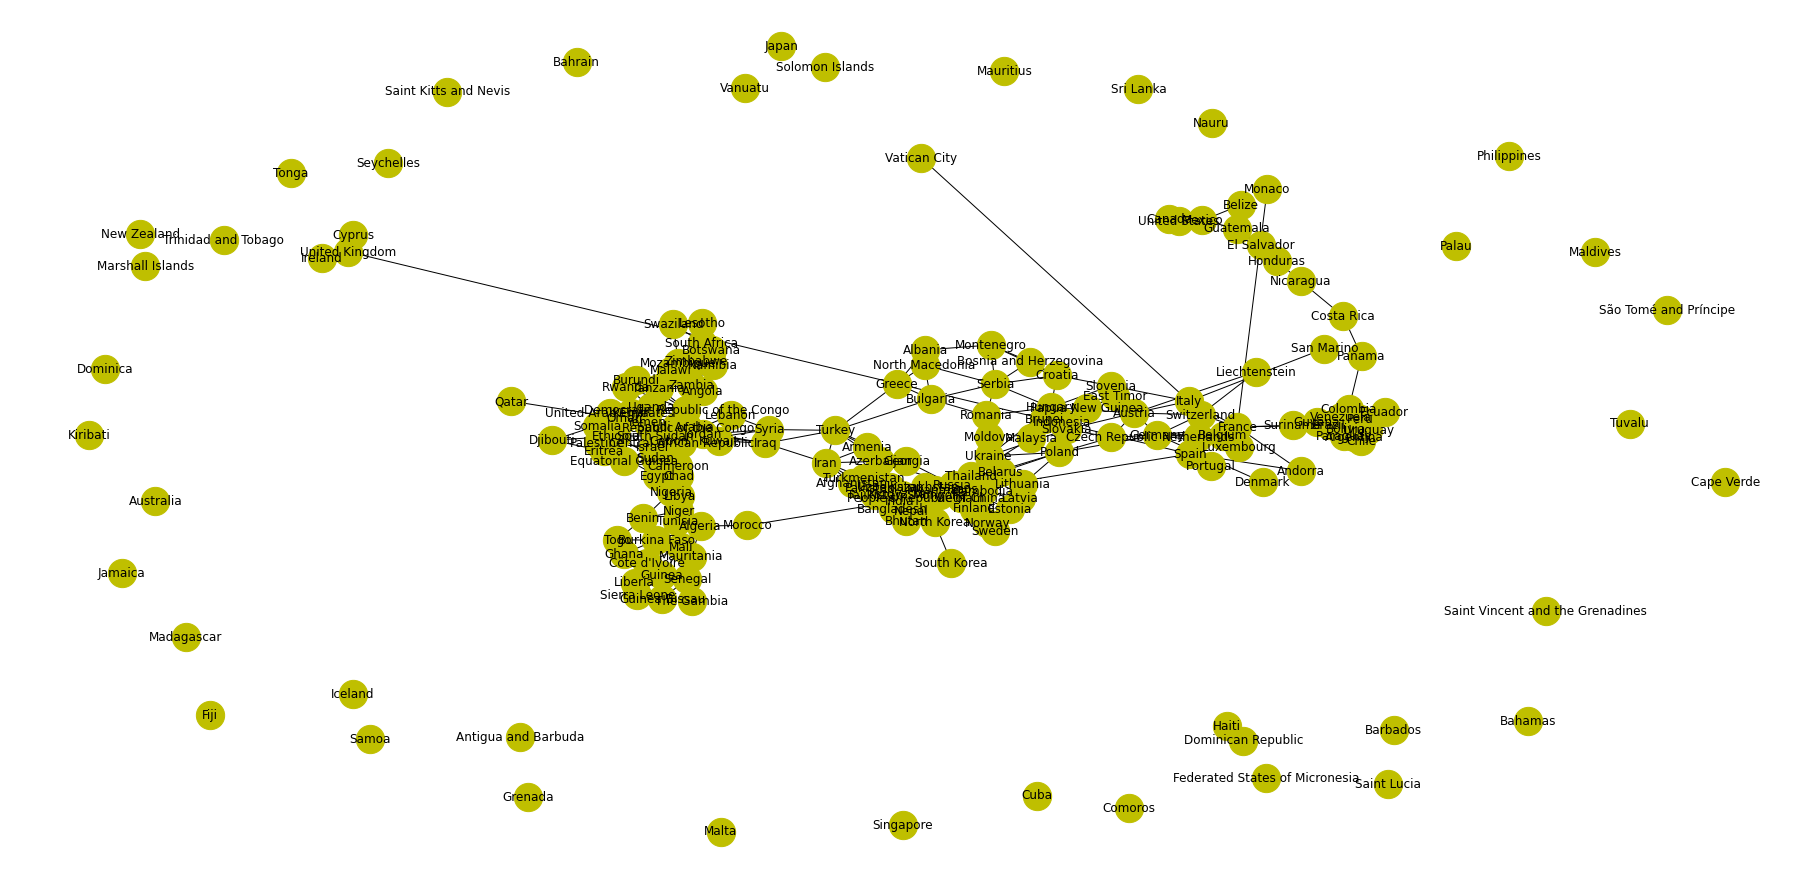

In [23]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='y')
plt.show()
# plt.savefig("graph.png", dpi=1000)

#### Transformando os nodes em valores numéricos

In [57]:
class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T


165


,0,1,2,7,8
Country,Afghanistan,Albania,Algeria,Antigua and Barbuda,Argentina
Country ID,0,1,2,3,4
Has coastline,0,1,1,1,1
Industrial,1,1,1,1,1
Agricultural,1,0,0,0,0
Services,0,1,0,1,1
High Literacy,1,1,1,1,1
GDP,0,1,2,3,3


In [58]:
df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [59]:
df_edges.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
source,0,0,0,0,0,0,1,2,2,2,2,4,4,4,4,4,5,5,5,5
target,113,71,108,143,151,158,59,91,93,103,149,18,20,30,112,157,8,56,71,150


# Montando o classificador
https://keras.io/examples/graph/gnn_citations/


In [60]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = 4


### Separando treino e teste

In [84]:
df_test

,Country,Country ID,Has coastline,Industrial,Agricultural,Services,High Literacy,GDP
0,Afghanistan,0,0,1,1,0,1,0.0
1,Albania,1,1,1,0,1,1,1.0
2,Algeria,2,1,1,0,0,1,2.0
7,Antigua and Barbuda,3,1,1,0,1,1,3.0
8,Argentina,4,1,1,0,1,1,3.0
...,...,...,...,...,...,...,...,...
218,Venezuela,160,1,1,0,1,1,2.0
219,Vietnam,161,1,1,0,0,1,1.0
224,Yemen,162,1,1,0,0,1,0.0
225,Zambia,163,0,1,0,0,1,0.0


In [61]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (127, 8)
Test data shape: (38, 8)


In [62]:
# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["GDP"]
y_test = test_data["GDP"]

### Testando um modelo baseline 
(Ainda não leva em consideração as conexões do grafo)

In [63]:
##  Feedforward Network (FFN) Module
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [64]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model( [32, 32], num_classes,  0.5)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 5)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1396        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [65]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam( 0.01),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=300,
        batch_size=256,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [66]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [67]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 4.2470 - acc: 0.2617 - val_loss: 1.4329 - val_acc: 0.2000
Epoch 2/300
1/1 [==============================] - 0s 24ms/step - loss: 3.1244 - acc: 0.2804 - val_loss: 1.4964 - val_acc: 0.0500
Epoch 3/300
1/1 [==============================] - 0s 24ms/step - loss: 2.8906 - acc: 0.2804 - val_loss: 1.5714 - val_acc: 0.0500
Epoch 4/300
1/1 [==============================] - 0s 24ms/step - loss: 2.6197 - acc: 0.2243 - val_loss: 1.6362 - val_acc: 0.0500
Epoch 5/300
1/1 [==============================] - 0s 32ms/step - loss: 2.2218 - acc: 0.3084 - val_loss: 1.6832 - val_acc: 0.0500
Epoch 6/300
1/1 [==============================] - 0s 24ms/step - loss: 2.2019 - acc: 0.2991 - val_loss: 1.6898 - val_acc: 0.0500
Epoch 7/300
1/1 [==============================] - 0s 32ms/step - loss: 2.0645 - acc: 0.3178 - val_loss: 1.6661 - val_acc: 0.0500
Epoch 8/300
1/1 [==============================] - 0s 32ms/step - loss: 2.3749 - acc: 0.2897

1/1 [==============================] - 0s 24ms/step - loss: 1.3623 - acc: 0.3178 - val_loss: 1.3906 - val_acc: 0.2000
Epoch 64/300
1/1 [==============================] - 0s 40ms/step - loss: 1.4100 - acc: 0.3925 - val_loss: 1.3901 - val_acc: 0.2000


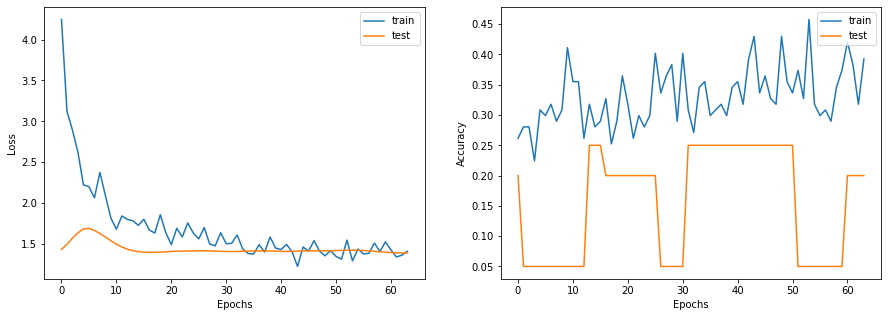

In [68]:
display_learning_curves(history)

In [69]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 26.32%


#### Examinando as predições do modelo baseline

In [70]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {countries_nodes[class_idx]}: {round(prob * 100, 2)}%")


In [71]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 240ms/step
Instance 1:
- Australia: 32.28%
- Fiji: 22.9%
- Kiribati: 24.41%
- Marshall Islands: 20.4%
Instance 2:
- Australia: 29.39%
- Fiji: 23.14%
- Kiribati: 23.9%
- Marshall Islands: 23.57%
Instance 3:
- Australia: 27.7%
- Fiji: 22.88%
- Kiribati: 27.03%
- Marshall Islands: 22.39%
Instance 4:
- Australia: 27.7%
- Fiji: 22.88%
- Kiribati: 27.03%
- Marshall Islands: 22.39%


### Modelo GNN - que considera os grafos

In [72]:

class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [73]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


#### Preparação dos dados

In [74]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

In [75]:
graph_info = (node_features, edges, edge_weights)
print("Node features shape:", node_features.shape)
print("Edges shape:", edges.shape)
print("edge_weights shape:", edge_weights.shape)

Node features shape: (165, 5)
Edges shape: (2, 228)
edge_weights shape: (228,)


#### Instanciando o modelo

In [76]:
edges.max()

164

In [77]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=0.5,
    name="gnn_model",
)


In [78]:
np.sort(edges)

array([[  0,   0,   0,   0,   0,   0,   1,   2,   2,   2,   2,   4,   4,
          4,   4,   4,   5,   5,   5,   5,   7,   7,   7,   7,   7,   8,
          8,   8,  11,  11,  13,  13,  13,  14,  14,  14,  15,  15,  16,
         16,  16,  16,  17,  17,  18,  18,  18,  18,  19,  19,  19,  19,
         20,  20,  20,  20,  20,  20,  20,  20,  21,  22,  22,  22,  23,
         23,  23,  23,  23,  24,  24,  25,  25,  25,  26,  26,  26,  26,
         26,  26,  28,  28,  28,  28,  29,  29,  29,  30,  31,  31,  31,
         31,  33,  33,  35,  36,  36,  37,  37,  37,  37,  38,  38,  38,
         38,  39,  40,  40,  40,  42,  43,  44,  45,  45,  46,  46,  47,
         48,  48,  49,  50,  50,  50,  53,  53,  54,  54,  54,  54,  54,
         55,  56,  57,  57,  57,  58,  59,  61,  61,  62,  62,  62,  62,
         62,  63,  64,  64,  66,  67,  67,  69,  69,  69,  70,  70,  71,
         71,  71,  71,  72,  72,  72,  72,  72,  73,  74,  74,  77,  77,
         78,  78,  78,  78,  79,  79,  80,  81,  81

In [79]:
gnn_model([1,10])

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 0.20140263, -0.21364102, -0.22574145, -0.17248626],
       [ 0.20149568, -0.21377142, -0.22566032, -0.1722712 ]],
      dtype=float32)>

In [80]:
gnn_model.summary()

Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (165, 32)                 1396      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (165, 32)                 2368      
                                                                 
 logits (Dense)              multiple                  132       
                                                                 
Total params: 15,672
Trainable params: 14,830
Non-trainab

In [85]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 1.9243 - acc: 0.2710 - val_loss: 1.4541 - val_acc: 0.0500
Epoch 2/300
1/1 [==============================] - 0s 24ms/step - loss: 1.6704 - acc: 0.2897 - val_loss: 1.4374 - val_acc: 0.0500
Epoch 3/300
1/1 [==============================] - 0s 32ms/step - loss: 1.5752 - acc: 0.2617 - val_loss: 1.4096 - val_acc: 0.1000
Epoch 4/300
1/1 [==============================] - 0s 32ms/step - loss: 1.7466 - acc: 0.2617 - val_loss: 1.3930 - val_acc: 0.3500
Epoch 5/300
1/1 [==============================] - 0s 24ms/step - loss: 1.4277 - acc: 0.3925 - val_loss: 1.3883 - val_acc: 0.3000
Epoch 6/300
1/1 [==============================] - 0s 32ms/step - loss: 1.5115 - acc: 0.2243 - val_loss: 1.3883 - val_acc: 0.3000
Epoch 7/300
1/1 [==============================] - 0s 32ms/step - loss: 1.3827 - acc: 0.3271 - val_loss: 1.3930 - val_acc: 0.3000
Epoch 8/300
1/1 [==============================] - 0s 32ms/step - loss: 1.4550 - acc: 0.2991

1/1 [==============================] - 0s 32ms/step - loss: 1.2935 - acc: 0.3645 - val_loss: 1.3105 - val_acc: 0.1500
Epoch 64/300
1/1 [==============================] - 0s 32ms/step - loss: 1.3125 - acc: 0.3458 - val_loss: 1.3099 - val_acc: 0.1500
Epoch 65/300
1/1 [==============================] - 0s 32ms/step - loss: 1.3341 - acc: 0.3084 - val_loss: 1.3096 - val_acc: 0.1500
Epoch 66/300
1/1 [==============================] - 0s 32ms/step - loss: 1.2827 - acc: 0.3738 - val_loss: 1.3087 - val_acc: 0.1500
Epoch 67/300
1/1 [==============================] - 0s 32ms/step - loss: 1.3421 - acc: 0.3178 - val_loss: 1.3066 - val_acc: 0.3000
Epoch 68/300
1/1 [==============================] - 0s 32ms/step - loss: 1.3478 - acc: 0.3832 - val_loss: 1.3053 - val_acc: 0.3000
Epoch 69/300
1/1 [==============================] - 0s 49ms/step - loss: 1.2483 - acc: 0.4860 - val_loss: 1.3031 - val_acc: 0.3000


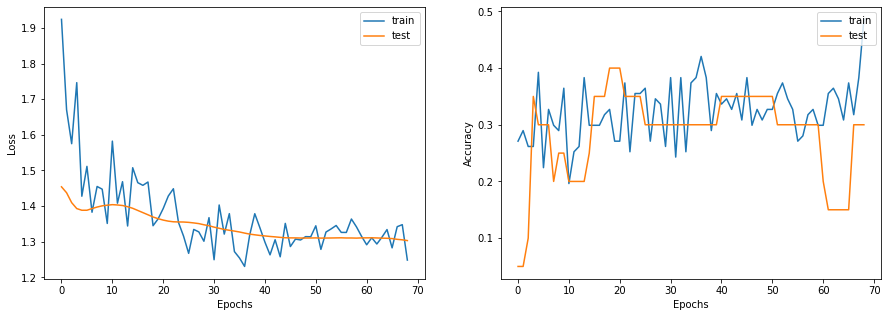

In [86]:
  
display_learning_curves(history)

In [89]:
x_test = test_data['Country ID'].to_numpy()

_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 39.47%
